# Human Activity Recognition (HAR) with Pytorch. 

En este ejemplo aprenderemos a procesar series de tiempo multi dimensionales. Entrenaremos dos modelos con distintos modelos. El primer modelo tendrá una arquietctura *feed forward*, *fully-connected*. El segundo modelo tendrá una arquitectura *CNN 1D + LSTM*. 

Usaremos estos modelos para reconocer el tipo de movimiento (caminar, correr, trotar, etc.) basado en los datos del acelerómetro de un dispositivo mobil que llevaron varios sujetos de prueba. Usaremos el conjunto de datos [WISDM](http://www.cis.fordham.edu/wisdm/dataset.php).


## Planteamiento del problema

El celular de varios sujetos de prueba regitró las siguientes seis actividades: bajar escaleras (*downstairs*), trotar (*jogging*), sentarse (*sitting*), estar de pie (*standing*), subir escaleras (*upstairs*) y caminar (*walking*). Para cada actividad se registro la aceleración en los ejes $x$, $y$ y $z$ con una captura de tiempo y el id de cada individuo.

La tarea de cada modelo propuesto será la de diferenciar cada una de las actividades a partir de las mediciones de la aceleración en las tres coordenadas. Este clasificador en el futuro deberá de ser capaz de predecir lo que esta haciendo el usuario si se decidiera implementar en una aplicación de dispositivos móviles.

## Bibliotecas 

**Nota**: Previamente se había utilizado una versión de ``torchsummary ``, para este trabajo es recomendable, hacer uso de esta [versión](https://github.com/sksq96/pytorch-summary/issues/124). 

`` pip3 uninstall torchsummary``

`` pip3 install torch-summary ``

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns


from matplotlib import pyplot as plt
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

from tqdm import tqdm
import time

Definiremos las variables ``LABELS`` para los nombres de las etiquetas. Después definiremos las constantes ``TIME_PERIODS`` para lo longitud de los segmentos de tiempo y  ``STEP_DISTANCE`` determina la cantidad de superposición entre dos segmentos de tiempo consecutivos.

In [2]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('torch version ', torch.__version__)
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

torch version  1.5.0


## Carga, inspección y transformación de los datos del acelerometro.

Los datos se encuentran almacenados en ``'WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'``. Definiremos algunas funciones para tratar los datos.

In [3]:
def convert_to_float(x):
    try: 
        return np.float(x)
    except:
        return np.nan

In [4]:
def read_data(file_path): 
    col_names = ['user-id', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
    dataframe = pd.read_csv(file_path, header=None, names=col_names)
    # Notice that the last column has a ";" character which most be removed ...
    dataframe['z-axis'].replace(regex=True, inplace=True, to_replace=r';', value=r'')
    # ... and then this column must be transformed to float
    dataframe['z-axis'] = dataframe['z-axis'].apply(convert_to_float)
    # This is very important for the model fitting
    dataframe.dropna(axis=0, how='any', inplace=True)
    
    return dataframe

In [5]:
def show_dataframe_info(df):
    print('Names of columns in the dataframe: %i '%(df.shape[1]))
    print('Names of rows in the dataframe: %i\n '%(df.shape[0]))

Cargamos los datos en la siguiente instrucción y observamos una sección del dataframe generado.

In [6]:
dataframe = read_data('HAR_pytorch/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')
show_dataframe_info(dataframe)

Names of columns in the dataframe: 6 
Names of rows in the dataframe: 1098203
 


In [7]:
dataframe.head(10)

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


Ahora veremos la cantidad de muestras por actividad.

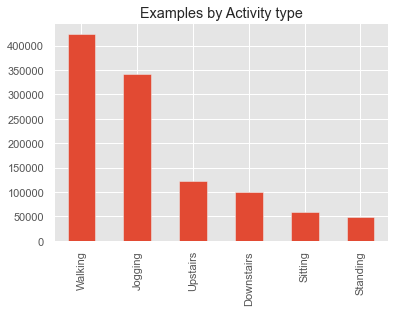

In [8]:
# Show how many training examples exist for each of the six activities 
dataframe['activity'].value_counts().plot(kind='bar', title='Examples by Activity type')
plt.show()

En la siguiente gráfica se obseva la cantidad de muestras que aporto cada uno de los 36 usuarios.

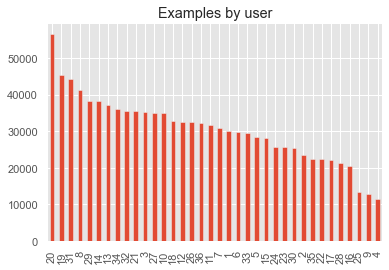

In [9]:
dataframe['user-id'].value_counts().plot(kind='bar', title='Examples by user')
plt.show()

In [10]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'b')
    ax.set_title(title)
    ax.xaxis.set_visible(True)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

Ahora visualizaremos las series de tiempo asociadas a cada actividad, tres por cada posición. Los datos fueron recabados a una velocidad de 20 Hz. Mostaremos 180 pasos, lo que equivale a 9 segundos.

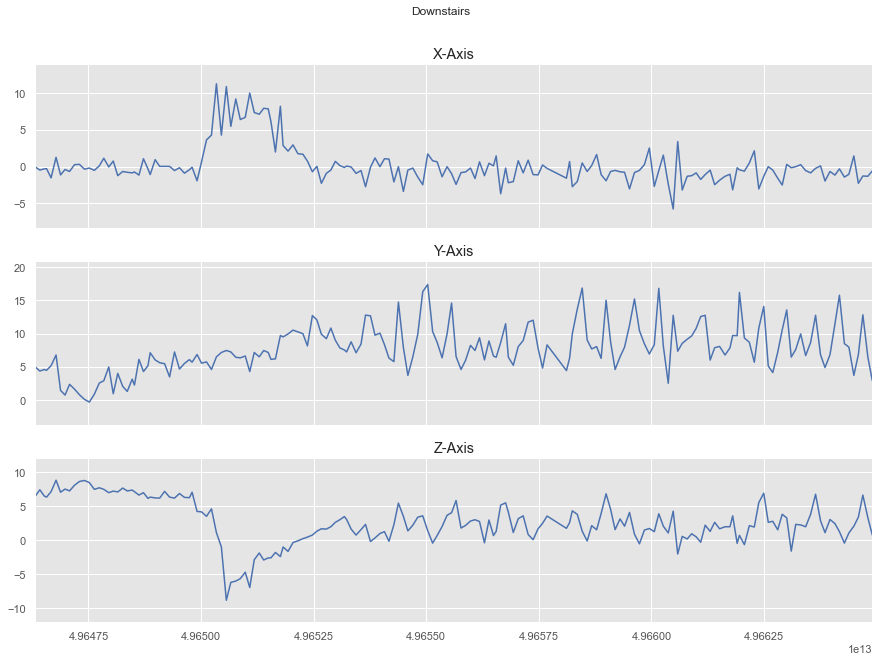

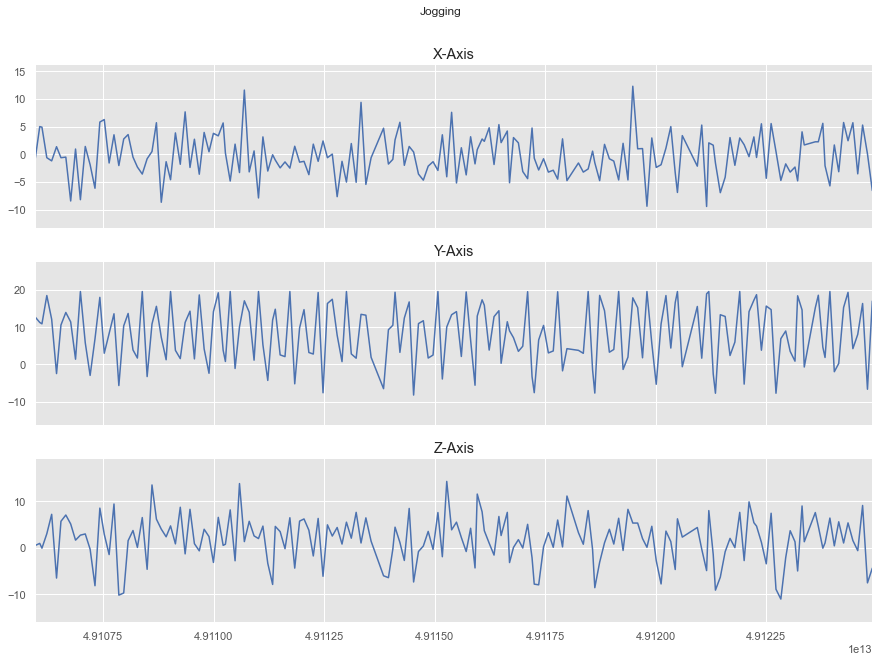

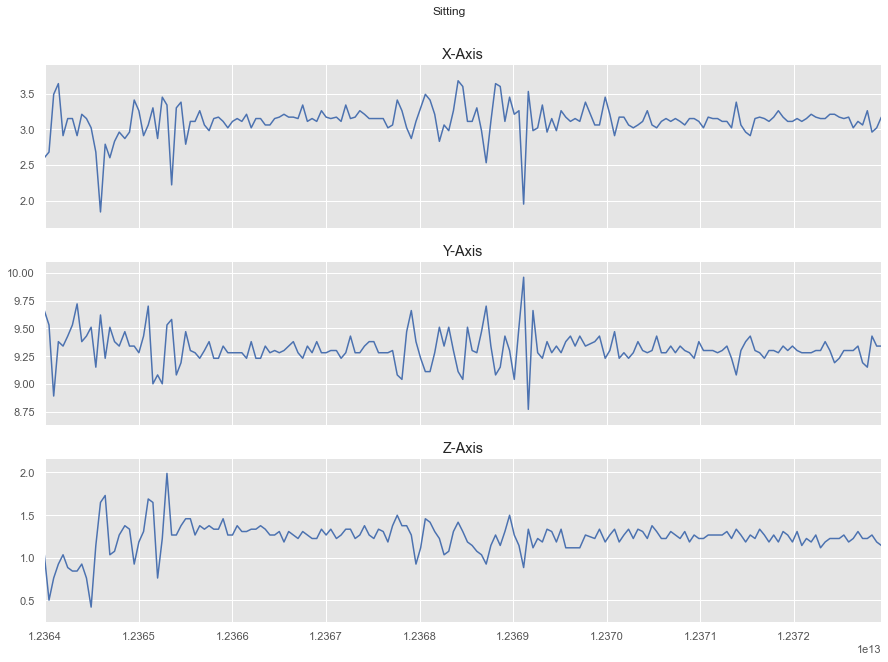

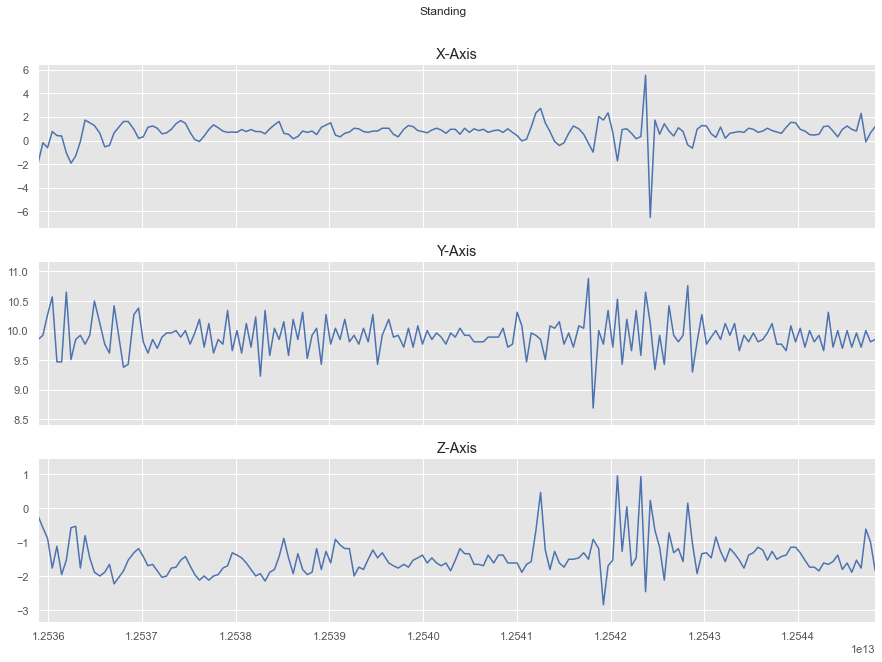

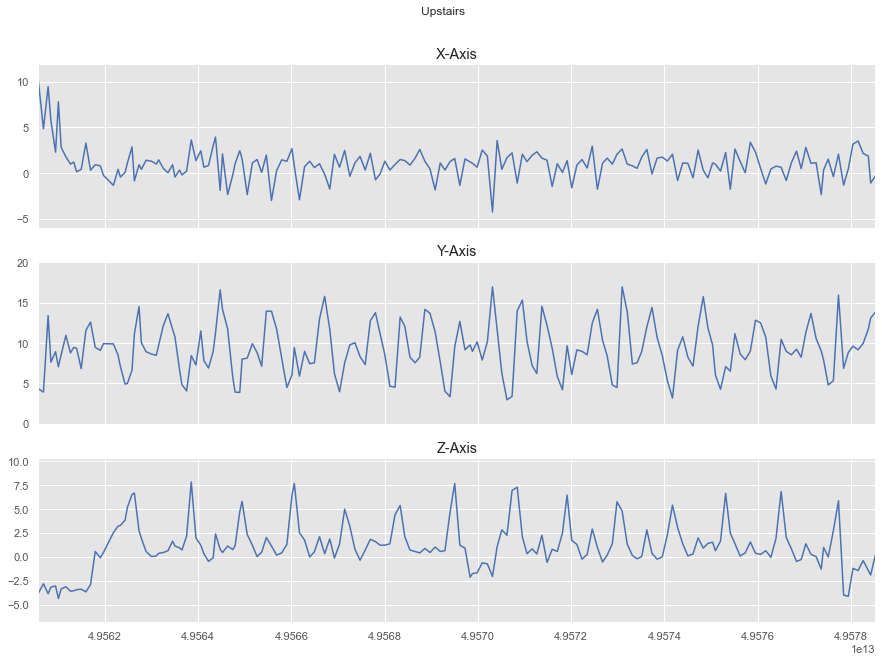

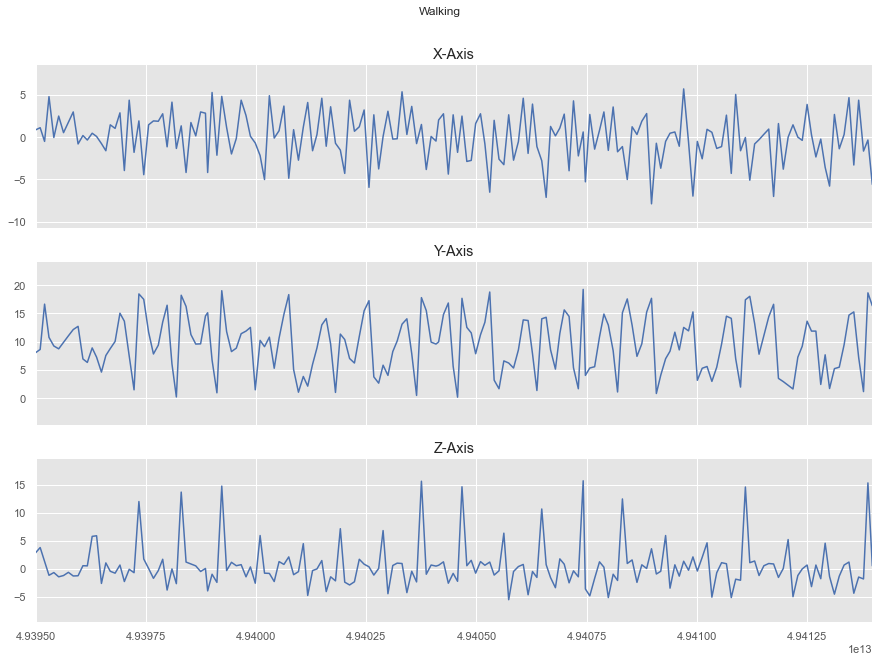

In [11]:
for activity in np.unique(dataframe['activity']):
    subset = dataframe[dataframe['activity'] == activity][:180]
    plot_activity(activity, subset)

Podemos observar que actividades más demandantes tienen mayor aceleración y cambia constantemente. 

This is needed since the deep neural network cannot work with non-numerical labels. with the LabelEncoder, we are able to easily to convert back to the original label text.

In [12]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
dataframe[LABEL] = le.fit_transform(dataframe['activity'].values.ravel())

## Separación del dataframe en entrenamiento y prueba

In [13]:
msk =  np.random.rand(len(dataframe)) < 0.80

train_df = dataframe[msk]
val_df = dataframe[~msk]

msk = np.random.rand(len(test_df1)) < 0.60
test_df = test_df1[msk]
val_df = test_df1[~msk]

## Normalización de los datos

In [14]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
train_df['x-axis'] = train_df['x-axis'] / train_df['x-axis'].max()
train_df['y-axis'] = train_df['y-axis'] / train_df['y-axis'].max()
train_df['z-axis'] = train_df['z-axis'] / train_df['z-axis'].max()
# Round numbers
train_df = train_df.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [15]:
'''
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
test_df['x-axis'] = test_df['x-axis'] / train_df['x-axis'].max()
test_df['y-axis'] = test_df['y-axis'] / train_df['y-axis'].max()
test_df['z-axis'] = test_df['z-axis'] / train_df['z-axis'].max()
# Round numbers
test_df = test_df.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})
'''

"\n# Normalize features for training data set (values between 0 and 1)\n# Surpress warning for next 3 operation\npd.options.mode.chained_assignment = None  # default='warn'\ntest_df['x-axis'] = test_df['x-axis'] / train_df['x-axis'].max()\ntest_df['y-axis'] = test_df['y-axis'] / train_df['y-axis'].max()\ntest_df['z-axis'] = test_df['z-axis'] / train_df['z-axis'].max()\n# Round numbers\ntest_df = test_df.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})\n"

In [16]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
val_df['x-axis'] = val_df['x-axis'] / val_df['x-axis'].max()
val_df['y-axis'] = val_df['y-axis'] / val_df['y-axis'].max()
val_df['z-axis'] = val_df['z-axis'] / val_df['z-axis'].max()
# Round numbers
val_df = val_df.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

## Preparación de datos para Pytorch

La siguiente función nos dará 80 pasos (un intervalo de 4 segundos) para cada posición, esta información será usada para ambas redes neuronales.

In [17]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [18]:
x_train, y_train = create_segments_and_labels(train_df, TIME_PERIODS, STEP_DISTANCE, LABEL)

x_test, y_test = create_segments_and_labels(test_df, TIME_PERIODS, STEP_DISTANCE, LABEL)

In [19]:
x_val, y_val = create_segments_and_labels(val_df, TIME_PERIODS, STEP_DISTANCE, LABEL)

Las siguientes instrucciones consisten en la codificación de los datos para que ``torch`` pueda trabajar con ellos.

In [20]:
# Training
x_train_tensor = torch.Tensor(x_train) # transform to torch tensor
y_train_tensor = torch.Tensor(y_train)

# Test
#x_test_tensor = torch.Tensor(x_test) # transform to torch tensor
#y_test_tensor = torch.Tensor(y_test)

# Test
x_val_tensor = torch.Tensor(x_val) # transform to torch tensor
y_val_tensor = torch.Tensor(y_val)

Observamos el tamaño de los datos de entrenamiento.

In [21]:
n_train = x_train_tensor.shape[0]
print(x_train.shape)
n_val = x_val_tensor.shape[0]
#n_test = x_test_tensor.shape[0]

(21980, 80, 3)


In [22]:
train_set = TensorDataset(x_train_tensor, y_train_tensor)
#test_set = TensorDataset(x_test_tensor, y_test_tensor)
val_set = TensorDataset(x_val_tensor, y_val_tensor)

In [23]:
train_loader = DataLoader(train_set, shuffle=True, batch_size=400)
val_loader = DataLoader(val_set, shuffle=False, batch_size=400)
#test_loader = DataLoader(test_set, shuffle=False, batch_size=400)

## Primer modelo

En este caso será necesario aplanar cada una de las muestras para que la red neuronal pueda trabajar con ellas.

### Definición de Arquitectura

In [24]:
input_size = 3 * 80
hidden_size= 100
classes = 6

class Net(nn.Module):
    def __init__(self,  input_size=input_size, hidden_size=hidden_size, classes=classes):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, classes)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        return self.linear4(x)
        

In [25]:
model = Net()

In [26]:
summary(model, (1, 3 * 80))

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 100]              24,100
├─Linear: 1-2                            [-1, 1, 100]              10,100
├─Linear: 1-3                            [-1, 1, 100]              10,100
├─Linear: 1-4                            [-1, 1, 6]                606
Total params: 44,906
Trainable params: 44,906
Non-trainable params: 0
Total mult-adds (M): 0.04
------------------------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.17
Estimated Total Size (MB): 0.17
------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 100]              24,100
├─Linear: 1-2                            [-1, 1, 100]              10,100
├─Linear: 1-3                            [-1, 1, 100]              10,100
├─Linear: 1-4                            [-1, 1, 6]                606
Total params: 44,906
Trainable params: 44,906
Non-trainable params: 0
Total mult-adds (M): 0.04
------------------------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.17
Estimated Total Size (MB): 0.17
------------------------------------------------------------------------------------------

In [27]:
print(model)

Net(
  (linear1): Linear(in_features=240, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=6, bias=True)
)


### Función de costos y optimizador

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

### Entrenamiento

In [29]:
def training_loop(epochs, train_loader, model, optimizer, loss_function, pbar, valid=False, conv1d=False):
    running_loss = 0.0
    correct = 0
    total = 0
    if valid: 
        model.eval() # modo de validación del modelo 
    for i, data in enumerate(train_loader, 0):
        X, Y = data
        if not conv1d:
            X = X.view(X.shape[0], -1) # transformamos los datos para la red
        else:
            m = X.shape[0]
            X = X.view(m, 3, 80)
            
        if not valid:
            optimizer.zero_grad() # reinicia el gradiente
            
        pred = model(X)
        Y = Y.type(torch.LongTensor) # https://stackoverflow.com/questions/60440292/runtimeerror-expected-scalar-type-long-but-found-float
        loss = loss_function(pred, Y)
        if not valid:
            loss.backward() # cálcula las derivadas 
            optimizer.step() # paso de optimización 
            
        running_loss += loss.item()
        
        avg_loss = running_loss/(i + 1)
        
        probs = F.softmax(pred, 1)
        label = torch.argmax(probs, dim=1)
        correct += torch.sum(label == Y).item()
        total += Y.shape[0]
        acc = correct/total
        
        pbar.set_postfix(avg_loss='{:.4f}'.format(avg_loss), acc='{:.4f}'.format(acc))
        #import pdb; pdb.set_trace()
        pbar.update(Y.shape[0])
        
    return avg_loss, acc

In [30]:
def train_model(epochs, model, optimizer, train_loader=train_loader, 
                val_loader=val_loader, criterion=criterion,
               n_train=n_train, n_val=n_val, conv1d=False):
    train_time = 0
    epoch_loss = []
    epoch_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(epochs):
        start_time = time.time()
        with tqdm(total = n_train, position=0) as pbar_train:
            pbar_train.set_description(f'Epoch {epoch + 1}/'+str(epochs)+' - training')
            pbar_train.set_postfix(avg_loss='0.0', acc='0.0')
            loss_train, acc_train = training_loop(epochs, train_loader, model, optimizer, 
                                                  criterion, pbar_train, valid=False, conv1d=conv1d)
            train_time +=  time.time() - start_time
        with tqdm(total = n_val, position=0) as pbar_val:
            pbar_val.set_description(f'Epoch {epoch +1}/'+str(epochs)+' - validation')
            pbar_val.set_postfix(avg_loss='0.0', acc='0.0')
            loss_val, acc_val = training_loop(epochs, val_loader, model, None, 
                                              criterion, pbar_val, valid=True, conv1d=conv1d)
    
        epoch_loss.append(loss_train)
        epoch_acc.append(acc_train)
        val_loss.append(loss_val)
        val_acc.append(acc_val)

    print("--- %s minutes ---", train_time)
    return epoch_loss, epoch_acc, val_loss, val_acc

In [31]:
epoch_loss, epoch_acc, val_loss, val_acc = train_model(50, model, optimizer, criterion=criterion)

Epoch 50/50 - validation: 100%|██████████| 5472/5472 [00:00<00:00, 37431.74it/s, acc=0.5905, avg_loss=2.1482]

--- %s minutes --- 30.69481873512268


### Rendimiento del modelo

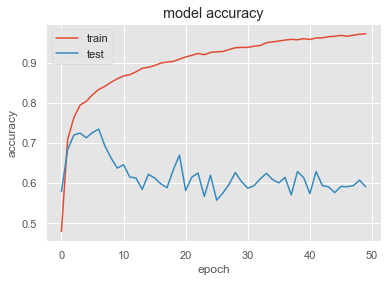

In [32]:
plt.plot(epoch_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

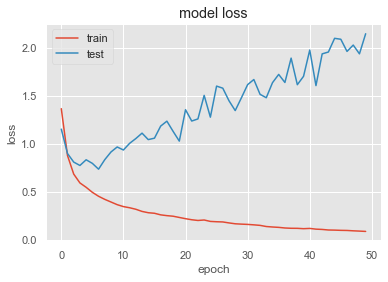

In [33]:
plt.plot(epoch_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Segundo modelo (CNN 1D + LSTM)

Este modelo se compone de inicialmente de capas convolucionales en una dimensión, capas recurrentes y finalmente un clasificador. Las capas convolusioanles extraen los rasgos temporales de una ventana de tiempo. Las capas recurrentes se encargan de extraer los rasgos temporales sobre el tiempo, por ejemplo, si el usuario estaba realizando una actividad, es muy probable que la siga realizando en el siguiente paso de tiempo y no cambie de actividad abruptamente.

![Esquema del model se obtuvo de [aquí](https://apple.github.io/turicreate/docs/userguide/activity_classifier/how-it-works.html)](HAR_pytorch/cnn_lstm.png)

El modelo para las capas recurrentes que usaremos lleva por nombre *Long Short Term Memory* (LSTM) que es un caso particular de las redes recurrentes. Este tipo de red fue introducido por Hochreiter & Schmidhuber (1997). Este modelo 
preserva la información por largos periodos de tiempo, esto se debe a su arquitectura recurrente.


Para mayor detalle de la red LSTM, se puede consultar esta [fuente](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

### LSTM en Pytorch

Usaremos la red predefinida de la biblioteca ``torch``, puede consultarse la documentación [aquí](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html).

![Estructura de LSTM [aquí](https://www.researchgate.net/figure/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell_fig5_329362532)](HAR_pytorch/lstm_net.png)

### Definición de Arquitectura

In [34]:
class HARmodel(nn.Module):
    def __init__(self, input_size=3, num_classes=classes):
        super(HARmodel, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3)
        self.conv2 = torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3)
        self.conv3 = torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3)
        self.lstm1 = torch.nn.LSTM(74, 128, 2)
        self.fc2 = torch.nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.dropout(x, p=0.5, training=True)
        x = F.relu(self.conv2(x))
        x = F.dropout(x, p=0.5, training=True)
        x = F.relu(self.conv3(x))
        x = F.dropout(x, p=0.5, training=True)
        x,_ = self.lstm1(x)
        x = F.dropout(x, p=0.5, training=True)
        x = x[:, -1, :]
        x = self.fc2(x)
        return x

In [35]:
har_model = HARmodel()

In [36]:
summary(har_model, (3, 80))

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 64, 78]              640
├─Conv1d: 1-2                            [-1, 64, 76]              12,352
├─Conv1d: 1-3                            [-1, 64, 74]              12,352
├─LSTM: 1-4                              [2, 64, 128]              236,544
├─Linear: 1-5                            [-1, 6]                   774
Total params: 262,662
Trainable params: 262,662
Non-trainable params: 0
Total mult-adds (M): 2.12
------------------------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 1.00
Estimated Total Size (MB): 1.24
------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 64, 78]              640
├─Conv1d: 1-2                            [-1, 64, 76]              12,352
├─Conv1d: 1-3                            [-1, 64, 74]              12,352
├─LSTM: 1-4                              [2, 64, 128]              236,544
├─Linear: 1-5                            [-1, 6]                   774
Total params: 262,662
Trainable params: 262,662
Non-trainable params: 0
Total mult-adds (M): 2.12
------------------------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 1.00
Estimated Total Size (MB): 1.24
------------------------------------------------------------------------------------------

In [37]:
print(har_model)

HARmodel(
  (conv1): Conv1d(3, 64, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (lstm1): LSTM(74, 128, num_layers=2)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


## Definición de optimizador

In [38]:
criterion1 = nn.CrossEntropyLoss()
har_optimizer = optim.Adam(har_model.parameters())

## Entrenamiento

In [39]:
epoch_loss, epoch_acc, val_loss, val_acc = train_model(20, har_model, har_optimizer, criterion=criterion1, conv1d=True)

Epoch 20/20 - validation: 100%|██████████| 5472/5472 [00:10<00:00, 543.03it/s, acc=0.7166, avg_loss=0.7426]

--- %s minutes --- 3524.596757888794


### Rendimiento

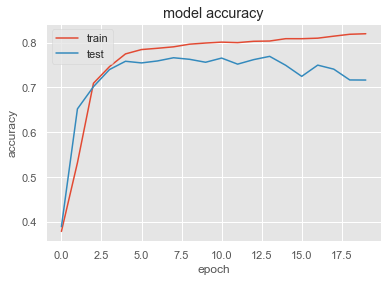

In [40]:
plt.plot(epoch_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

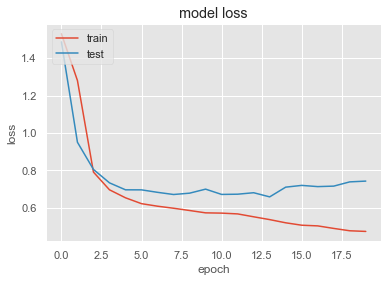

In [41]:
plt.plot(epoch_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Prueba del modelo

running_loss = 0.0
correct = 0
total = 0
for i, data in enumerate(test_loader, 0):
    X, Y = data
    m = X.shape[0]
    X = X.view(m, 3, 80)      
    pred = har_model(X)
    loss = criterion(pred, Y)
    running_loss += loss.item()
    avg_loss = running_loss/(i + 1)
    probs = F.softmax(pred, 1)
    label = torch.argmax(probs, dim=1)
    correct += torch.sum(label == Y).item()
    total += Y.shape[0]
    acc = correct/total
        
print('accuracy: {}, loss: {}'.format(acc, avg_loss))

### Guardar el modelo

In [42]:
torch.save(har_model.state_dict(), "HAR_pytorch/models/cnn_lstm.pth")


## Conclusión

En este trabajo contrastamos el rendiemiento de un modelo simple de redes neuronales con un modelo de deep learnig. En el segundo modelo pudimos observar que mejora notablemente la precisión del modelo. La red *CNN 1D + LSTM* muestra que el uso de las capas recurrentes complementan bastante bien a la parte convolusional, pues extrae información que no es posible obtener por medio de la convolusión. Este último modelo resulta ser mucho más amplio, ya que considera los rasgos a lo largo de una ventana de tiempo con lo que mejora la capacidad predictiva del modelo.

## Referencias

Este trabajo fue basado en los siguietes artículos de divulgación:

* https://apple.github.io/turicreate/docs/userguide/activity_classifier/how-it-works.html.
* https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0
* https://medium.com/@curiousily/human-activity-recognition-using-lstms-on-android-tensorflow-for-hackers-part-vi-492da5adef64

También fue de gran utilidad el paper [Deep Convolutional and LSTM Recurrent Neural Networks for Multimodal Wearable Activity Recognition](https://www.mdpi.com/1424-8220/16/1/115/htm).